In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from pickle import load
from keras.models import load_model


In [2]:
df = pd.read_csv('Amreli NRM data for model building2.csv')

df = df[df['Heat number (life number)']>1]    
df = df.reset_index(drop=True)
df['Number of capacitors removed'].fillna(0, inplace=True)

In [3]:
df['Efficiency (MT/KWH)'] = df['Efficiency (MT/KWH)']*1000
df['Previous Output'] = df['Previous Output']*1000
df['Previous Input'] = df['Previous Input']*1000
df['Scrap (MT)'] = df['Scrap (MT)']*1000
df['Sponge (MT)'] = df['Sponge (MT)']*1000
df['Alloys (MT)'] = df['Alloys (MT)']*1000

In [4]:
model = load_model("model.h5")
scaler1 = load(open('scaler1.pkl', 'rb'))
scaler2 = load(open('scaler2.pkl', 'rb'))

In [14]:


from scipy.optimize import minimize, LinearConstraint
dfc = df[df['campaign']==9]
dfc = dfc.reset_index(drop=True)
R = np.array(dfc['Refractory lining before heating'])



In [15]:
# Setting initial condition

import random

randomlist = []
for i in range(dfc.shape[0]):
    n = random.randint(2,8)
    randomlist.append(np.abs(n))
print(randomlist)
# R0 = np.ones((dfc.shape[0],1))*4
# R0 = R
# R0 = np.zeros((dfc.shape[0],1))
R0 = randomlist

[7, 2, 2, 8, 7, 5, 6, 3, 3, 7, 8, 3, 6, 5, 3, 3, 2, 8, 2, 6, 7, 8, 7, 4, 3, 7, 2, 2, 3, 3, 2, 4, 6, 4, 6, 2, 7, 3, 7, 7, 2, 2, 7, 2, 6, 2, 8, 2, 8, 3, 8, 3, 7, 4, 7, 8, 4, 2, 3, 7, 3, 5]


In [16]:
def objective_function(Coef):
    dfc['Refractory lining before heating'] = Coef
    
    input_columns = ['Scrap (MT)', 'Sponge (MT)', 'Hot Heel (MT)', 'Alloys (MT)','Number of capacitors removed','Tapping Temperature (C)','Refractory lining before heating',
             'Previous Voltage', 'Previous Frequency','Previous Input', 'Previous Output','Input energy previous (KWH)']
    output_columns = ['Efficiency (MT/KWH)']
    X = dfc[input_columns]
    X_test = X.iloc[:,:].values
    y = dfc[output_columns]
    y_test = y.iloc[:,:].values
    normalized_X_test = scaler1.transform(X_test)
    normalized_y_test = scaler2.transform(y_test)
    pred_test = model.predict(normalized_X_test)
    y_pred_test = scaler2.inverse_transform(pred_test)
    sum_of_squares = np.sum(np.square(y_test-y_pred_test))
    return sum_of_squares

In [17]:

def inequality(Coef):
    A = np.zeros((dfc.shape[0]-1,dfc.shape[0]))
    for i in range(dfc.shape[0]-1):
        A[i,i] = 1
        A[i,i+1] = -1

 
    return np.matmul(A,Coef)-0.001



bounds = [(2, 7) for _ in range(dfc.shape[0])]
con1 = {'type':'ineq','fun':inequality}

con = [con1]






In [18]:
res = minimize(objective_function, x0 = R0, constraints=con,bounds=bounds,method='SLSQP',
               options={'ftol': 1e-8, 'disp': True})
res

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4378201761944268
            Iterations: 3
            Function evaluations: 192
            Gradient evaluations: 3


     fun: 0.4378201761944268
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 192
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([7.        , 4.86647972, 4.86546891, 4.81851284, 4.81751284,
       4.81651284, 4.81551284, 4.73813165, 4.73414781, 4.71986196,
       4.71886196, 4.71786196, 4.71686196, 4.71586196, 4.71486196,
       4.71386196, 4.71286196, 4.71180793, 4.71080793, 4.69358146,
       4.68236383, 4.68136383, 4.68036383, 4.67936383, 4.67836383,
       4.64043991, 4.47428667, 4.47327586, 4.46504969, 4.46404969,
       4.46304969, 4.44761896, 4.44118853, 4.44018853, 4.43918853,
       4.43818853, 4.43577283, 4.43477283, 4.43377283, 4.43277283,
       4.43177283, 4.43

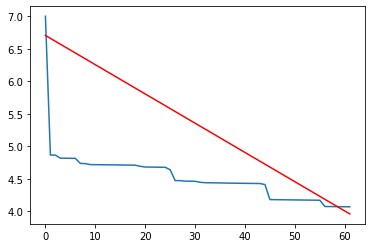

In [19]:
plt.figure()
plt.plot(res.x)
plt.plot(R,c='r')

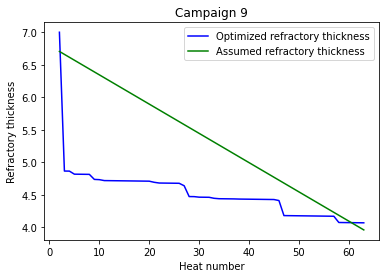

In [23]:
plt.plot(dfc['Heat number (life number)'],res.x,c='b');
plt.plot(dfc['Heat number (life number)'],R,c='g');
plt.xlabel('Heat number');
plt.ylabel('Refractory thickness');
plt.title('Campaign 9');
plt.legend(['Optimized refractory thickness','Assumed refractory thickness']);
plt.show();

In [11]:
res.x

array([6.2706032 , 6.2696032 , 6.2686032 , 6.2676032 , 6.2666032 ,
       6.2656032 , 6.2646032 , 6.2636032 , 6.2626032 , 6.2616032 ,
       6.2606032 , 6.2596032 , 6.2586032 , 6.2576032 , 6.2566032 ,
       6.2556032 , 6.2546032 , 6.2536032 , 6.2526032 , 6.2516032 ,
       6.2506032 , 6.2496032 , 6.2486032 , 6.2476032 , 4.61481404,
       4.61381404, 4.38723594, 4.38623594, 4.38523594, 4.38423594,
       4.38323594, 4.38223594, 4.38123594, 4.38023594, 4.37923594,
       4.37823594, 4.37723594, 4.37623594, 4.37523594, 4.37423594,
       4.37323594, 4.37223594, 4.37123594, 4.32698751, 4.30288238,
       4.30188238, 4.30088238, 4.29988238, 4.29888238, 4.29788238,
       4.29688238, 4.29588238, 4.29488238, 4.29388238, 4.29288238,
       4.29188238, 4.1315799 , 4.1305799 , 3.52783038, 3.52683038])

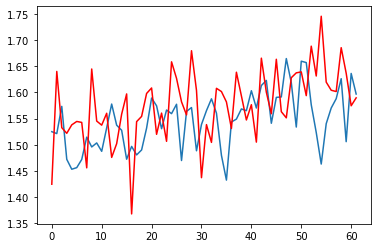

In [20]:
dfc['Refractory lining before heating'] = res.x

input_columns = ['Scrap (MT)', 'Sponge (MT)', 'Hot Heel (MT)', 'Alloys (MT)','Number of capacitors removed','Tapping Temperature (C)','Refractory lining before heating',
         'Previous Voltage', 'Previous Frequency','Previous Input', 'Previous Output','Input energy previous (KWH)']
output_columns = ['Efficiency (MT/KWH)']
X = dfc[input_columns]
X_test = X.iloc[:,:].values
y = dfc[output_columns]
y_test = y.iloc[:,:].values
normalized_X_test = scaler1.transform(X_test)
normalized_y_test = scaler2.transform(y_test)
pred_test = model.predict(normalized_X_test)
y_pred_test = scaler2.inverse_transform(pred_test)

plt.figure()

plt.plot(y_pred_test)
plt.plot(y_test,c='r')



In [25]:
dfc['Refractory lining before heating'] = R
input_columns = ['Scrap (MT)', 'Sponge (MT)', 'Hot Heel (MT)', 'Alloys (MT)','Number of capacitors removed','Tapping Temperature (C)','Refractory lining before heating',
             'Previous Voltage', 'Previous Frequency','Previous Input', 'Previous Output','Input energy previous (KWH)']
output_columns = ['Efficiency (MT/KWH)']
X = dfc[input_columns]
X_test = X.iloc[:,:].values
y = dfc[output_columns]
y_test = y.iloc[:,:].values
normalized_X_test = scaler1.transform(X_test)
normalized_y_test = scaler2.transform(y_test)
pred_test_prev = model.predict(normalized_X_test)
y_pred_test_prev = scaler2.inverse_transform(pred_test_prev)

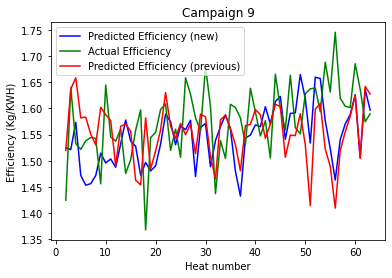

In [28]:
plt.plot(dfc['Heat number (life number)'],y_pred_test,c='b');
plt.plot(dfc['Heat number (life number)'],y_test,c='g');
plt.plot(dfc['Heat number (life number)'],y_pred_test_prev,c='r');
plt.xlabel('Heat number');
plt.ylabel('Efficiency (Kg/KWH)');
plt.title('Campaign 9');
plt.legend(['Predicted Efficiency (new)','Actual Efficiency','Predicted Efficiency (previous)']);
plt.show();

In [21]:
for i in range(1):
    print(output_columns[i])
    print("R2 score is {}".format(r2_score(y_test[:,i], y_pred_test[:,i])))
    print("Test NMSE score is {}".format(np.sum(np.square(y_pred_test[:,i]-y_test[:,i]))/np.sum(np.square(y_test[:,i]-np.mean(y_test[:,i])))*100))

Efficiency (MT/KWH)
R2 score is -0.5652136393020377
Test NMSE score is 156.52136393020376
